In [ ]:
# %time !python prepare_data.py

args: Namespace(root_dir='.')
Preparing triviaqa validation Qwen: 100%|████| 100/100 [00:00<00:00, 264.33it/s]
Preparing triviaqa validation meta-llama: 100%|█| 100/100 [00:00<00:00, 342.60it
Preparing triviaqa test meta-llama: 100%|████| 100/100 [00:00<00:00, 358.30it/s]
Done!
CPU times: user 1.42 s, sys: 332 ms, total: 1.75 s
Wall time: 1min 9s


In [28]:
%load_ext autoreload
%autoreload 2

import json
import warnings
import os
import pickle
from tqdm import tqdm
import torch
from collections import defaultdict, Counter
import argparse
from core.models.entailment import EntailmentDeberta
from core.data.data_utils import load_ds_from_json
import numpy as np
import pandas as pd
import scipy
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, roc_auc_score, mean_squared_error
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore")
plt.rcParams.update({'font.size': 12})
rng = np.random.default_rng(42)


def load_pickle_file(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    return data

def save_pickle_file(file_path, data):
    with open(file_path, 'wb') as f:
        pickle.dump(data, f)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# 查看数据
result = load_pickle_file("output/result/Qwen/Qwen2.5-7B-Instruct/squad_train.pkl")
print(len(result["id"]))
print(result["data"][result["id"][0]].keys())
d = result["data"][result["id"][0]]
print(d.keys())
print(d['golden']['greedy']['tbg_emb'].shape) # torch.Size([29, 1, 3584])
print(d)

2000
dict_keys(['example', 'golden', 'irrelevant', 'without'])
dict_keys(['example', 'golden', 'irrelevant', 'without'])
torch.Size([29, 1, 3584])
defaultdict(<class 'dict'>, {'example': {'id': '57313c0a497a881900248cae', 'question': 'How were pigments like red lake created?', 'context': 'Unlike vermilion or red ochre, made from minerals, red lake pigments are made by mixing organic dyes, made from insects or plants, with white chalk or alum. Red lac was made from the gum lac, the dark red resinous substance secreted by various scale insects, particularly the Laccifer lacca from India. Carmine lake was made from the cochineal insect from Central and South America, Kermes lake came from a different scale insect, kermes vermilio, which thrived on oak trees around the Mediterranean. Other red lakes were made from the rose madder plant and from the brazilwood tree.', 'answers': ['mixing organic dyes'], 'irrelevant_id': '57268318708984140094c88b', 'irrelevant_context': 'One of the paper\'s 

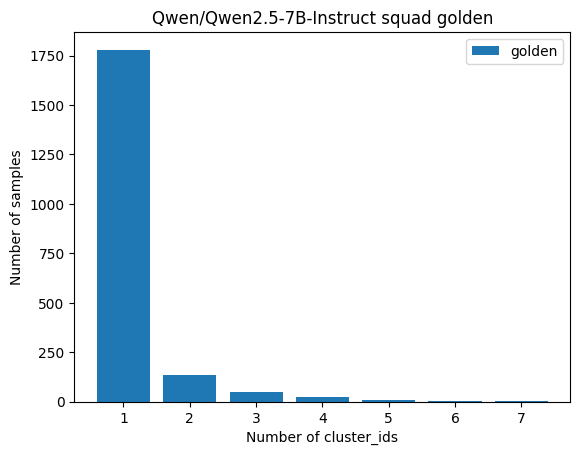

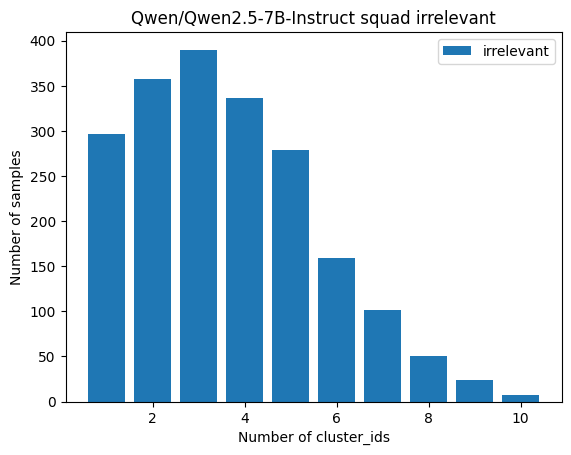

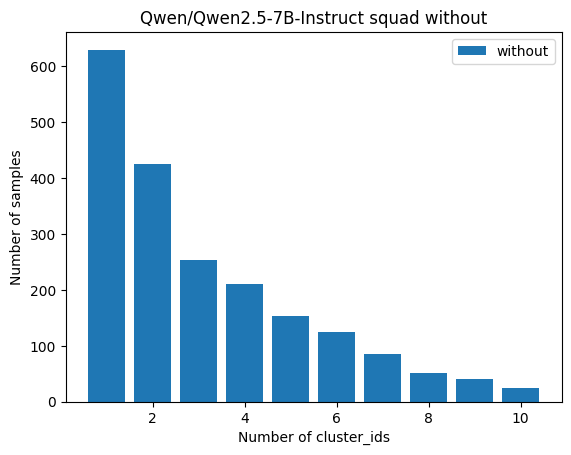

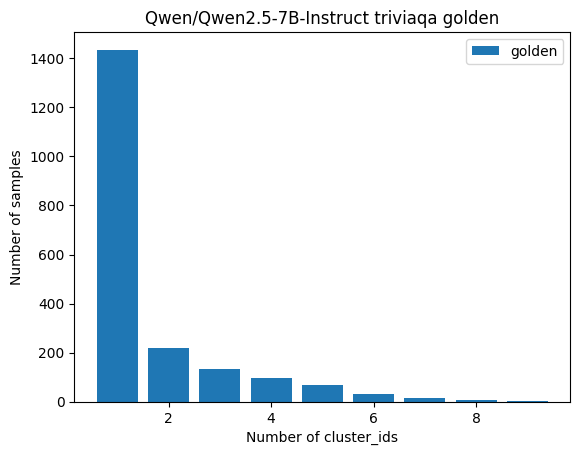

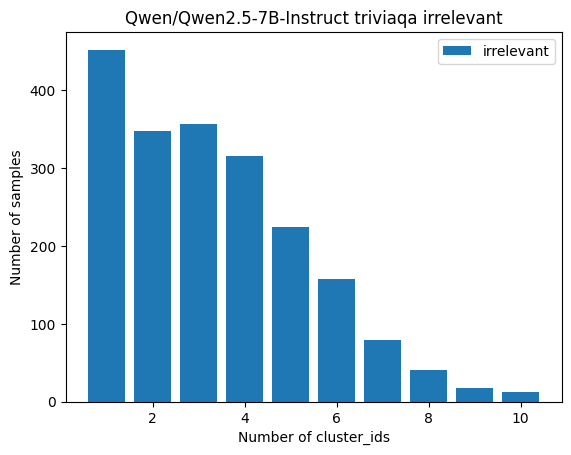

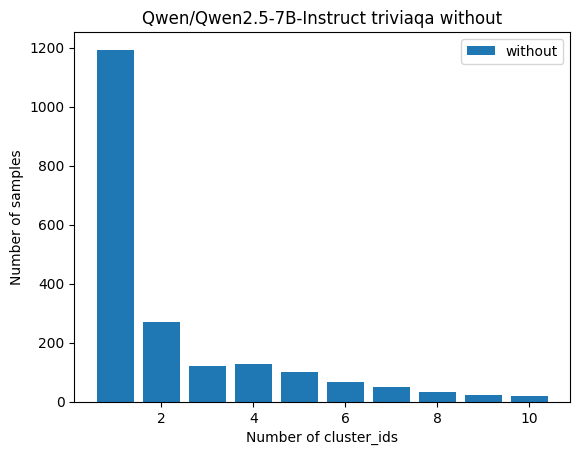

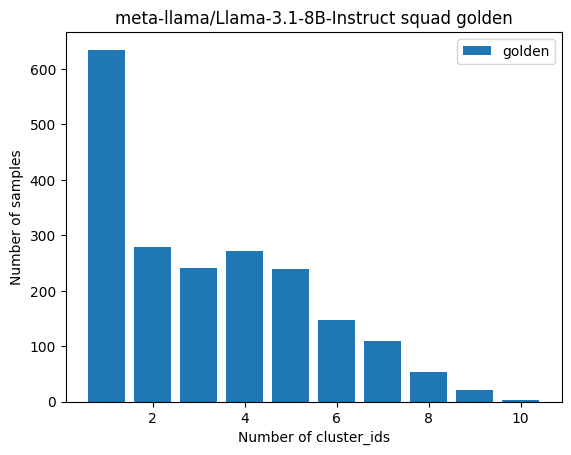

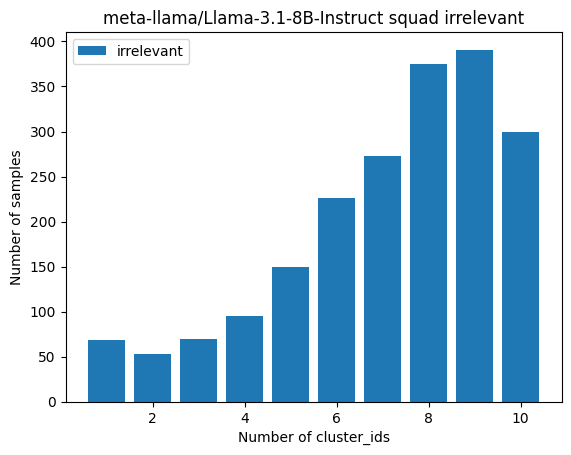

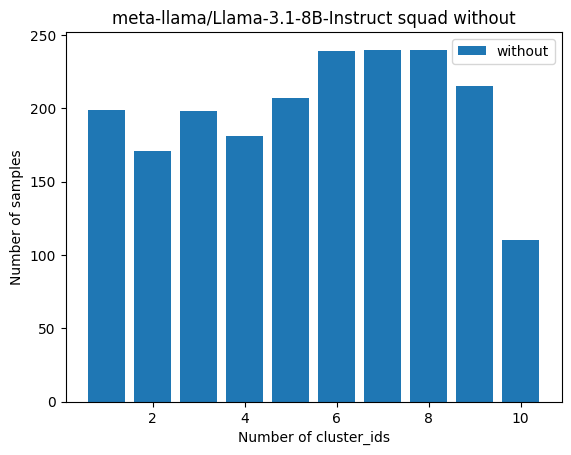

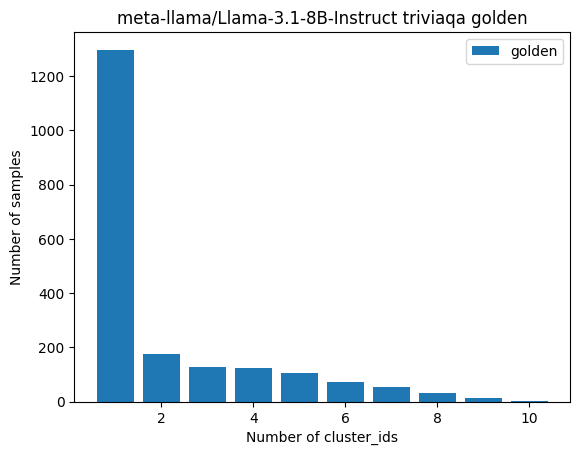

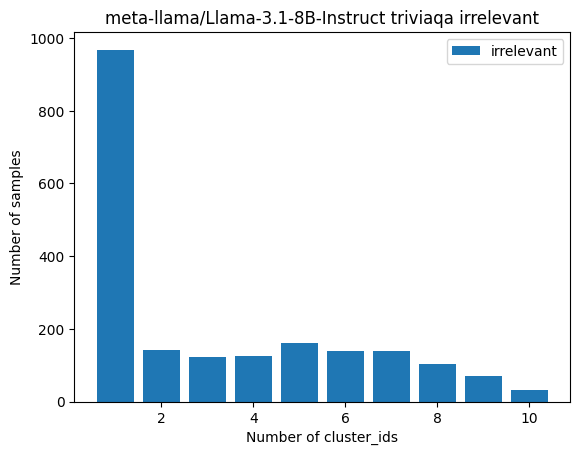

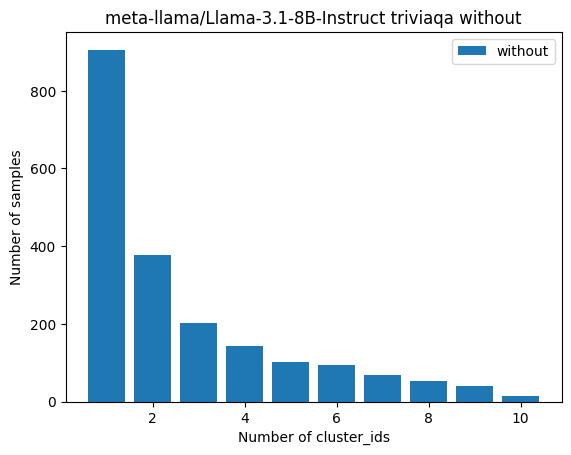

CPU times: user 6.84 s, sys: 7.18 s, total: 14 s
Wall time: 14 s


In [4]:
# 聚簇数量分布
def stat_cluster_ids(result):
    from collections import Counter
    gen_counts = defaultdict(Counter)
    for data in result["data"].values():
        for sample_type in ['golden', 'irrelevant', 'without']:
            cluster_ids = data[sample_type]['cluster_ids']
            # 计算cluster_ids中不同元素的个数（聚簇数量）
            num_cluster_ids = len(set(cluster_ids))
            gen_counts[sample_type].update([num_cluster_ids])
    return gen_counts

def visualize_cluster_ids_distribution(gen_counts, model_name, dataset_name):
    # 可视化分布
    import matplotlib.pyplot as plt
    import seaborn as sns
    for sample_type in ['golden', 'irrelevant', 'without']:
        x, y = zip(*sorted(gen_counts[sample_type].items()))
        plt.bar(x, y, label=sample_type)
        plt.legend()
        plt.xlabel('Number of cluster_ids')
        plt.ylabel('Number of samples')
        plt.title(f'{model_name} {dataset_name} {sample_type}')
        plt.show()

def do_stat_cluster_ids():
    model_names = ["Qwen/Qwen2.5-7B-Instruct", "meta-llama/Llama-3.1-8B-Instruct"]
    dataset_names = ["squad", "triviaqa"]
    for model_name in model_names:
        for dataset_name in dataset_names:
            result = load_pickle_file(f"output/result/{model_name}/{dataset_name}_train.pkl")
            gen_counts = stat_cluster_ids(result)
            visualize_cluster_ids_distribution(gen_counts, model_name, dataset_name)

%time do_stat_cluster_ids()

In [10]:
# 统计模型针对数据集的三种不同采样的准确率和语义熵
def stat_accuracy(result):
    accs = {}
    for data in result["data"].values():
        for sample_type in ['golden', 'irrelevant', 'without']:
            greedy = data[sample_type]['greedy']
            if greedy is None:
                continue
            acc = greedy['accuracy']
            if sample_type not in accs:
                accs[sample_type] = []
            accs[sample_type].append(acc)
    return accs

def stat_entropy(result):
    entropies = {}
    for data in result["data"].values():
        for sample_type in ['golden', 'irrelevant', 'without']:
            d = data[sample_type]
            entropy = d['entropy']
            if sample_type not in entropies:
                entropies[sample_type] = []
            entropies[sample_type].append(entropy)
    return entropies

def do_stat_accuracy():
    model_names = ["Qwen/Qwen2.5-7B-Instruct", "meta-llama/Llama-3.1-8B-Instruct"]
    dataset_names = ["squad", "triviaqa"]
    splits = ["train", "validation", "test"]
    for model_name in model_names:
        for dataset_name in dataset_names:
            for split in splits:
                print(f"{model_name} {dataset_name} {split}:")
                result = load_pickle_file(f"output/result/{model_name}/{dataset_name}_{split}.pkl")
                stat_acc = stat_accuracy(result)
                stat_ent = stat_entropy(result)
                for sample_type in ['golden', 'irrelevant', 'without']:
                    print(f"> {sample_type} accuracy: {sum(stat_acc[sample_type]) / len(stat_acc[sample_type]):.3f}")
                    print(f"> {sample_type} entropy: {sum(stat_ent[sample_type]) / len(stat_ent[sample_type]):.3f}")

%time do_stat_accuracy()

Qwen/Qwen2.5-7B-Instruct squad train:
> golden accuracy: 0.876
> golden entropy: 0.085
> irrelevant accuracy: 0.111
> irrelevant entropy: 0.995
> without accuracy: 0.260
> without entropy: 0.766
Qwen/Qwen2.5-7B-Instruct squad validation:
> golden accuracy: 0.880
> golden entropy: 0.105
> irrelevant accuracy: 0.140
> irrelevant entropy: 1.090
> without accuracy: 0.300
> without entropy: 0.734
Qwen/Qwen2.5-7B-Instruct squad test:
> golden accuracy: 0.880
> golden entropy: 0.072
> irrelevant accuracy: 0.210
> irrelevant entropy: 1.037
> without accuracy: 0.340
> without entropy: 0.603
Qwen/Qwen2.5-7B-Instruct triviaqa train:
> golden accuracy: 0.822
> golden entropy: 0.271
> irrelevant accuracy: 0.421
> irrelevant entropy: 0.883
> without accuracy: 0.619
> without entropy: 0.447
Qwen/Qwen2.5-7B-Instruct triviaqa validation:
> golden accuracy: 0.820
> golden entropy: 0.301
> irrelevant accuracy: 0.450
> irrelevant entropy: 0.844
> without accuracy: 0.640
> without entropy: 0.498
Qwen/Qwen2

In [24]:
# Create Dataset class for easier attribute keeping
class Dataset:
    meta = {
        'sample_type': '',
        'model_name': '',
        'dataset_name': '',
        'split': '',
    }
    def __init__(self, values):
        self.tbg_dataset = values[0]
        self.slt_dataset = values[1]
        self.entropy = values[2]
        self.accuracies = values[3]

def make_data(model_name, dataset_name, split, sample_type):
    result = load_pickle_file(f"output/result/{model_name}/{dataset_name}_{split}.pkl")

    # 聚合tbg_emb, slt_emb, entropy, accuracies
    tbg_datasets = []
    slt_datasets = []
    entropies = []
    accuracies = []
    for data in result["data"].values():
        d = data[sample_type]
        greedy = d['greedy']
        if greedy is None:
            continue
        accuracy = greedy['accuracy']
        if accuracy is None:
            continue
        tbg_emb = greedy['tbg_emb']
        if tbg_emb is None:
            continue
        slt_emb = greedy['slt_emb']
        if slt_emb is None:
            continue

        if 'entropy' not in d:
            continue
        entropy = d['entropy']
        tbg_datasets.append(tbg_emb)
        slt_datasets.append(slt_emb)
        entropies.append(entropy)
        accuracies.append(accuracy)
    
    # print(f"{model_name} {dataset_name} {split}: {len(tbg_datasets)}")
    tbg_datasets = torch.stack(tbg_datasets).squeeze(-2).transpose(0, 1).to(torch.float32)
    slt_datasets = torch.stack(slt_datasets).squeeze(-2).transpose(0, 1).to(torch.float32)
    entropies = torch.tensor(entropies).to(torch.float32)
    accuracies = torch.tensor(accuracies).to(torch.float32)
    # print(tbg_datasets.shape)
    # print(slt_datasets.shape)
    # print(entropies.shape)
    # print(accuracies.shape)
    # print(len(tbg_datasets))
    ds = Dataset((tbg_datasets, slt_datasets, entropies, accuracies))
    ds.name = dataset_name
    ds.path = f"output/data/{model_name}/{dataset_name}"
    ds.meta['sample_type'] = sample_type
    ds.meta['model_name'] = model_name
    ds.meta['dataset_name'] = dataset_name
    ds.meta['split'] = split
    return ds
    

def do_make_data():
    model_names = ["Qwen/Qwen2.5-7B-Instruct", "meta-llama/Llama-3.1-8B-Instruct"]
    dataset_names = ["squad", "triviaqa"]
    splits = ["train", "validation", "test"]
    sample_types = ['golden', 'irrelevant', 'without']
    all_data = {}
    for model_name in model_names:
        all_data[model_name] = {}
        for dataset_name in dataset_names:
            all_data[model_name][dataset_name]  = {}
            for split in splits:
                all_data[model_name][dataset_name][split] = {}
                for sample_type in sample_types:
                    all_data[model_name][dataset_name][split][sample_type] = make_data(model_name, dataset_name, split, sample_type)
    return all_data

%time all_data = do_make_data()

model_names = ["Qwen/Qwen2.5-7B-Instruct", "meta-llama/Llama-3.1-8B-Instruct"]
dataset_names = ["squad", "triviaqa"]
splits = ["train", "validation", "test"]
sample_types = ['golden', 'irrelevant', 'without']
for model_name in model_names:
    for dataset_name in dataset_names:
        for split in splits:
            for sample_type in sample_types:
                ds = all_data[model_name][dataset_name][split][sample_type]
                print(f"{model_name} {dataset_name} {split} {sample_type}: {len(ds.accuracies)}")

CPU times: user 2min 15s, sys: 1min 10s, total: 3min 25s
Wall time: 34.3 s
Qwen/Qwen2.5-7B-Instruct squad train golden: 2000
Qwen/Qwen2.5-7B-Instruct squad train irrelevant: 2000
Qwen/Qwen2.5-7B-Instruct squad train without: 2000
Qwen/Qwen2.5-7B-Instruct squad validation golden: 100
Qwen/Qwen2.5-7B-Instruct squad validation irrelevant: 100
Qwen/Qwen2.5-7B-Instruct squad validation without: 100
Qwen/Qwen2.5-7B-Instruct squad test golden: 100
Qwen/Qwen2.5-7B-Instruct squad test irrelevant: 100
Qwen/Qwen2.5-7B-Instruct squad test without: 100
Qwen/Qwen2.5-7B-Instruct triviaqa train golden: 2000
Qwen/Qwen2.5-7B-Instruct triviaqa train irrelevant: 1999
Qwen/Qwen2.5-7B-Instruct triviaqa train without: 2000
Qwen/Qwen2.5-7B-Instruct triviaqa validation golden: 100
Qwen/Qwen2.5-7B-Instruct triviaqa validation irrelevant: 100
Qwen/Qwen2.5-7B-Instruct triviaqa validation without: 100
Qwen/Qwen2.5-7B-Instruct triviaqa test golden: 100
Qwen/Qwen2.5-7B-Instruct triviaqa test irrelevant: 100
Qwen/Qwe

In [25]:
model_name = "Qwen/Qwen2.5-7B-Instruct"
split = "train"
sample_type = "without"
dataset_names = ["squad", "triviaqa"]

Ds = []
for dataset_name in dataset_names:
    ds = all_data[model_name][dataset_name][split][sample_type]
    Ds.append(ds)

for i, D in enumerate(Ds):
    # OOD-related
    D.other_ids = [j for j in range(len(Ds)) if j != i]
    D.other_names = [dataset_names[j] for j in D.other_ids]

Ds

[<__main__.Dataset at 0x76037f9bbc50>, <__main__.Dataset at 0x7603a18d7ad0>]

### Helper Methods

In [29]:
# Create train/val/test splits
def create_Xs_and_ys(datasets, scores, val_test_splits=[0.2, 0.1], test_only=False, no_val=False):
    # Data splitting for sklearn linear models
    X = np.array(datasets)
    y = np.array(scores)

    if test_only:
        X_tests, y_tests = [], []
        
        for i in range(X.shape[0]):
            X_tests.append(X[i])
            y_tests.append(y)
        return (None, None, X_tests, None, None, y_tests)
    
    valid_size = val_test_splits[0]
    test_size = val_test_splits[1]

    X_trains, X_vals, X_tests, y_trains, y_vals, y_tests = [], [], [], [], [], []

    for i in range(X.shape[0]):
        # Split data into train, validation, and test sets
        X_train_val, X_test, y_train_val, y_test = train_test_split(X[i], y, test_size=test_size, random_state=42)
        X_tests.append(X_test)
        y_tests.append(y_test)
        if no_val:
            X_trains.append(X_train_val)
            y_trains.append(y_train_val)
            continue
        X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=valid_size, random_state=42) 
        X_trains.append(X_train)
        y_trains.append(y_train)
        X_vals.append(X_val)
        y_vals.append(y_val)

    return X_trains, X_vals, X_tests, y_trains, y_vals, y_tests


In [30]:
# Bootstrapping methods from ../semantic_entropy/uncertainty/utils/eval_utils.py
def bootstrap_func(y_true, y_score, func):
    y_tuple = (y_true, y_score)
    
    metric_i = func(*y_tuple)
    metric_dict = {}
    metric_dict['mean'] = metric_i
    metric_dict['bootstrap'] = compatible_bootstrap(
        func, rng)(*y_tuple)  # a bit slow to run

    return metric_dict

def bootstrap(function, rng, n_resamples=1000):
    def inner(data):
        bs = scipy.stats.bootstrap(
            (data, ), function, n_resamples=n_resamples, confidence_level=0.9,
            random_state=rng)
        return {
            'std_err': bs.standard_error,
            'low': bs.confidence_interval.low,
            'high': bs.confidence_interval.high
        }
    return inner

def auroc(y_true, y_score):
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_score)
    del thresholds
    return metrics.auc(fpr, tpr)

def compatible_bootstrap(func, rng):
    def helper(y_true_y_score):
        # this function is called in the bootstrap
        y_true = np.array([i['y_true'] for i in y_true_y_score])
        y_score = np.array([i['y_score'] for i in y_true_y_score])
        out = func(y_true, y_score)
        return out

    def wrap_inputs(y_true, y_score):
        return [{'y_true': i, 'y_score': j} for i, j in zip(y_true, y_score)]

    def converted_func(y_true, y_score):
        y_true_y_score = wrap_inputs(y_true, y_score)
        return bootstrap(helper, rng=rng)(y_true_y_score)
    return converted_func

In [31]:
# Train and evaluation function.
def sklearn_train_and_evaluate(model, X_train, y_train, X_valid, y_valid, silent=False):
    model.fit(X_train, y_train)
    
    # Calculate training loss and score
    train_probs = model.predict_proba(X_train)
    train_loss = log_loss(y_train, train_probs)

    # Calculate validation loss
    valid_preds = model.predict(X_valid)
    valid_probs = model.predict_proba(X_valid)
    valid_loss = log_loss(y_valid, valid_probs)
    val_accuracy = np.mean((valid_preds == y_valid).astype(int))
    auroc_score = roc_auc_score(y_valid, valid_probs[:,1])
    if not silent:
        print(f"Validation Accuracy: {val_accuracy:.4f}, AUROC: {auroc_score:.4f}")
        print(f"Training Loss: {train_loss:.4f}, Validation Loss: {valid_loss:.4f}")

def sklearn_evaluate_on_test(model, X_test, y_test, silent=False, bootstrap=True):
    test_preds = model.predict(X_test)
    test_probs = model.predict_proba(X_test)
    test_loss = log_loss(y_test, test_probs)
    test_accuracy = np.mean((test_preds == y_test).astype(int))
    
    if bootstrap:
        auroc_score = bootstrap_func(y_test, test_probs[:,1], auroc)
        auroc_score_scalar = auroc_score['mean']
    else:
        auroc_score = auroc_score_scalar = roc_auc_score(y_test, test_probs[:, 1])
    
    if not silent:
        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, AUROC: {auroc_score_scalar:.4f}")
    
    return test_loss, test_accuracy, auroc_score

def train_single_metric(D, token_type='tbg', metric='b_entropy'):
    """train and test on single metric (e.g. SE, Acc) on single dataset"""
    var_name = token_type[0] + metric[0] 
    # named as [te, se. ta, sa] for easy identification; t for tbg, s for slt (token positions)
    # e for entropy and a for accuracy (or model faithfulness)
    X_trains, X_vals, X_tests, y_trains, y_vals, y_tests = create_Xs_and_ys(
        getattr(D, f'{token_type}_dataset'), getattr(D, metric)
    )

    accs = []
    aucs = []
    models = []
    
    for i, (X_train, X_val, X_test, y_train, y_val, y_test) in enumerate(zip(X_trains, X_vals, X_tests, y_trains, y_vals, y_tests)):
        print(f"Training on {D.name}-{token_type.upper()}-{metric.upper()} {i+1}/{len(X_trains)}")
        model = LogisticRegression()
        sklearn_train_and_evaluate(model, X_train, y_train, X_val, y_val)
        test_loss, test_acc, test_auc = sklearn_evaluate_on_test(model, X_test, y_test)
        accs.append(test_acc)
        aucs.append(test_auc)
        models.append(model)

    setattr(D, f'{var_name}_accs', accs)
    setattr(D, f'{var_name}_aucs', aucs)
    setattr(D, f'{var_name}_models', models)

# simple get-around for unpacking bootstrapping dicts
auc = lambda aucs : [ac['mean'] for ac in aucs] 
idf = lambda x : x  # identical function

In [33]:
# Plotting methods
def plot_metrics_ax(ax, test_metrics_list, model_names, title="", prep_func=auc, 
                    use_logarithm=False, preset_layer_indices=None, legend_outside=False):  # some simple gadgets
    """plot metrics along certain axis in a multi-axis plot (plt.subplots)"""
    if len(test_metrics_list) != len(model_names):
        raise ValueError("The length of test_metrics_list and model_names must be the same.")
    
    for test_metrics, model_name in zip(test_metrics_list, model_names):
        test_metrics = torch.tensor(prep_func(test_metrics), dtype=torch.float32)
        if use_logarithm:
            test_metrics = torch.log(test_metrics + 1e-6)
        if preset_layer_indices is not None:
            layer_indices = preset_layer_indices
        else:
            layer_indices = torch.arange(len(test_metrics)) + 1  # +1 if layer indexing starts at 1
        
        ax.plot(layer_indices, test_metrics, marker='o', linestyle='-', linewidth=2, markersize=5, label=model_name)
    
    ax.set_title(f'{title}', fontsize=14)
    ax.set_xlabel('Layer', fontsize=12)
    ax.set_ylabel(f'Test AUROC scores', fontsize=12)
    
    tick_interval = 5  # Change this value to display more or fewer ticks
    ax.set_xticks(layer_indices[::tick_interval].tolist())
    ax.set_xticklabels(layer_indices[::tick_interval].tolist())
    
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    
    if legend_outside:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)
    else:
        ax.legend(fontsize=12)

def save_fig(name):
    """save figure with timestamps"""
    full_path = f'output/data/figures'
    full_path = os.path.expanduser(full_path)
    os.makedirs(full_path, exist_ok=True)
    plt.savefig(f'{full_path}/{name}.pdf', format='pdf', dpi=300)

In [34]:
# Best split for SE binarization.
def best_split(entropy: torch.Tensor, label="Dx"):
    """
    Identify best split for minimizing reconstruction error via low and high SE mean estimates,
    as discussed in Section 4. Binarization of paper (ArXiv: 2406.15927)
    """
    ents = entropy.numpy()
    splits = np.linspace(1e-10, ents.max(), 100)
    split_mses = []
    for split in splits:
        low_idxs, high_idxs = ents < split, ents >= split
    
        low_mean = np.mean(ents[low_idxs])
        high_mean = np.mean(ents[high_idxs])
    
        mse = np.sum((ents[low_idxs] - low_mean)**2) + np.sum((ents[high_idxs] - high_mean)**2)
        mse = np.sum(mse)
    
        split_mses.append(mse)
    
    split_mses = np.array(split_mses)
    
    plt.plot(splits, split_mses, label=label)
    return splits[np.argmin(split_mses)]

def binarize_entropy(entropy, thres=0.0):  # 0.0 means even splits for normalized entropy scores
    """Binarize entropy scores into 0s and 1s"""
    binary_entropy = torch.full_like(entropy, -1, dtype=torch.float)
    binary_entropy[entropy < thres] = 0
    binary_entropy[entropy > thres] = 1

    return binary_entropy

### 二值化语义熵

Dummy accuracy for squad: 0.5490
Dummy accuracy for triviaqa: 0.7395


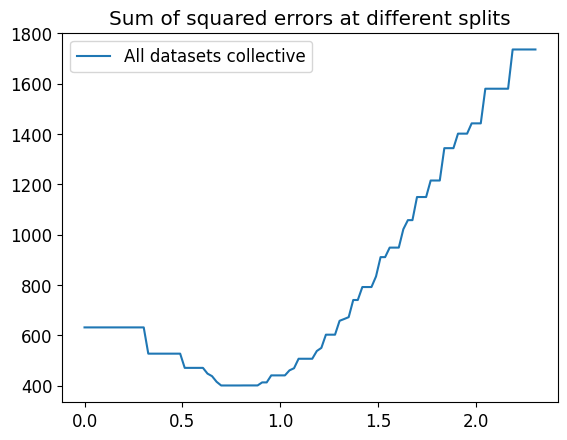

In [35]:
# Best universal split across datasets
split_method = 'best-universal-split'
all_entropy = torch.cat([D.entropy for D in Ds], dim=0)
split = best_split(all_entropy, "All datasets collective")
plt.legend()
plt.title('Sum of squared errors at different splits')
for D in Ds:
    D.b_entropy = binarize_entropy(D.entropy, split)
    print(f"Dummy accuracy for {D.name}: {max(torch.mean(D.b_entropy).item(), 1-torch.mean(D.b_entropy).item()):.4f}")

### Train linear probes to predict Binarized SE

In [36]:
for D in Ds:
    train_single_metric(D, 'tbg', 'b_entropy')
    train_single_metric(D, 'slt', 'b_entropy')

Training on squad-TBG-B_ENTROPY 1/29
Validation Accuracy: 0.5500, AUROC: 0.5000
Training Loss: 0.6862, Validation Loss: 0.6883
Test Loss: 0.7061, Test Accuracy: 0.4750, AUROC: 0.5000
Training on squad-TBG-B_ENTROPY 2/29
Validation Accuracy: 0.5694, AUROC: 0.6010
Training Loss: 0.5827, Validation Loss: 0.6779
Test Loss: 0.7098, Test Accuracy: 0.5150, AUROC: 0.5682
Training on squad-TBG-B_ENTROPY 3/29
Validation Accuracy: 0.5806, AUROC: 0.6134
Training Loss: 0.5389, Validation Loss: 0.6750
Test Loss: 0.7153, Test Accuracy: 0.5550, AUROC: 0.5765
Training on squad-TBG-B_ENTROPY 4/29
Validation Accuracy: 0.5889, AUROC: 0.6056
Training Loss: 0.5093, Validation Loss: 0.7082
Test Loss: 0.7107, Test Accuracy: 0.5700, AUROC: 0.5972
Training on squad-TBG-B_ENTROPY 5/29
Validation Accuracy: 0.5778, AUROC: 0.6108
Training Loss: 0.4864, Validation Loss: 0.7234
Test Loss: 0.7327, Test Accuracy: 0.5500, AUROC: 0.5952
Training on squad-TBG-B_ENTROPY 6/29
Validation Accuracy: 0.6056, AUROC: 0.6301
Train

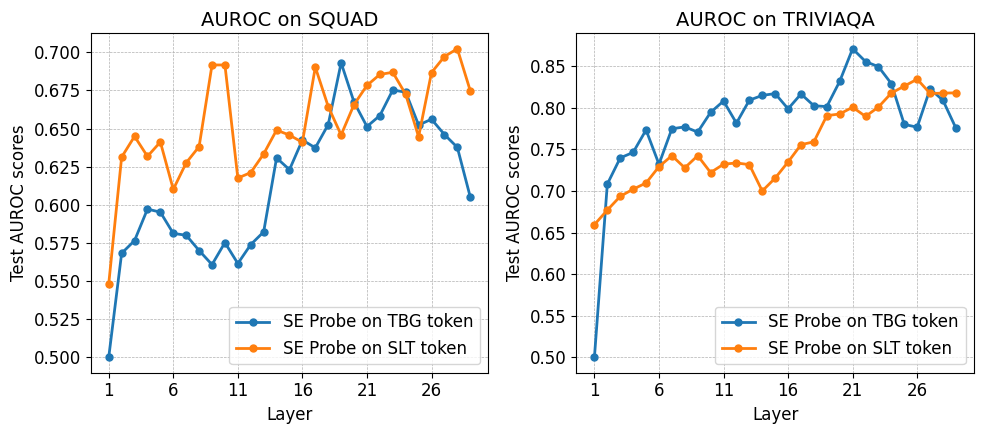

In [37]:
# plot se probe
fig, axs = plt.subplots(1, len(Ds), figsize=(5 * len(Ds), 4.5))
for i, D in enumerate(Ds):
    plot_metrics_ax(axs[i], [auc(D.tb_aucs), auc(D.sb_aucs)], ["SE Probe on TBG token", "SE Probe on SLT token"], 
                    f"AUROC on {D.name.upper()}", prep_func=idf)
plt.tight_layout()
save_fig(name="se_both_tok")
plt.show()

### Train linear probes to predict Accuracy

In [38]:
for D in Ds:
    train_single_metric(D, 'tbg', 'accuracies')
    train_single_metric(D, 'slt', 'accuracies')

Training on squad-TBG-ACCURACIES 1/29
Validation Accuracy: 0.7167, AUROC: 0.5000
Training Loss: 0.5706, Validation Loss: 0.5978
Test Loss: 0.5413, Test Accuracy: 0.7700, AUROC: 0.5000
Training on squad-TBG-ACCURACIES 2/29
Validation Accuracy: 0.7167, AUROC: 0.5886
Training Loss: 0.4906, Validation Loss: 0.5889
Test Loss: 0.5678, Test Accuracy: 0.7600, AUROC: 0.5116
Training on squad-TBG-ACCURACIES 3/29
Validation Accuracy: 0.7083, AUROC: 0.6390
Training Loss: 0.4543, Validation Loss: 0.5765
Test Loss: 0.5621, Test Accuracy: 0.7350, AUROC: 0.5600
Training on squad-TBG-ACCURACIES 4/29
Validation Accuracy: 0.7083, AUROC: 0.6237
Training Loss: 0.4106, Validation Loss: 0.5956
Test Loss: 0.5436, Test Accuracy: 0.7300, AUROC: 0.6407
Training on squad-TBG-ACCURACIES 5/29
Validation Accuracy: 0.7361, AUROC: 0.6178
Training Loss: 0.4009, Validation Loss: 0.6155
Test Loss: 0.5734, Test Accuracy: 0.7150, AUROC: 0.6064
Training on squad-TBG-ACCURACIES 6/29
Validation Accuracy: 0.6889, AUROC: 0.6228

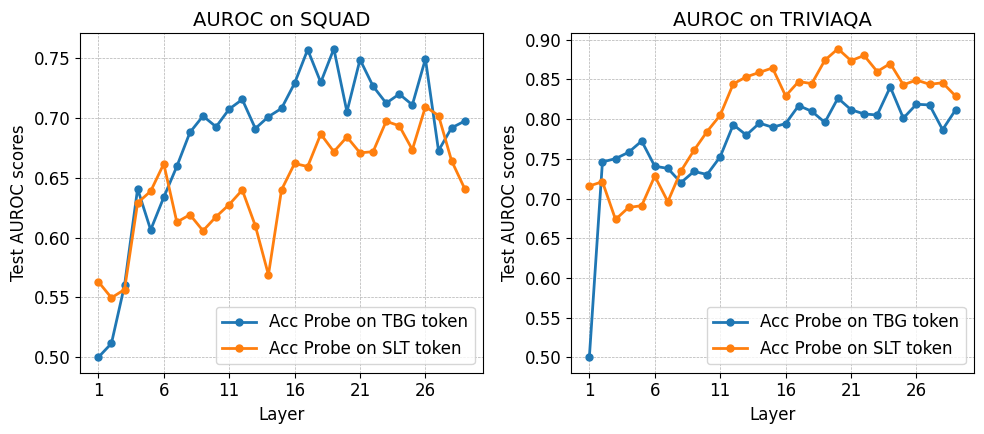

In [39]:
# plot acc probe
fig, axs = plt.subplots(1, len(Ds), figsize=(5 * len(Ds), 4.5))
for i, D in enumerate(Ds):
    plot_metrics_ax(axs[i], [auc(D.ta_aucs), auc(D.sa_aucs)], ["Acc Probe on TBG token", "Acc Probe on SLT token"], 
                    f"AUROC on {D.name.upper()}", prep_func=idf)
plt.tight_layout()
save_fig(name="acc_both_tok")
plt.show()

### Use linear probe trained on Binarized SE to predict Accuracy

We leverage trained probes on semantic entropy to predict model correctness on the same dataset.

Note that we need to predict the error rate (1 minus accuracy) using SEPs due to the nature of semantic uncertainty.

In [40]:
for D in Ds:
    r_acc = 1 - D.accuracies
    
    # TBG
    _, _, X_tests, _, _, y_tests = create_Xs_and_ys(D.tbg_dataset, r_acc) 
    tab_accs = []
    tab_aucs = []
    
    for i, (X_test, y_test) in enumerate(zip(X_tests, y_tests)):
        print(f"Testing on {D.name}-TBG {i+1}/{len(X_tests)}")
        model = D.tb_models[i]
        test_loss, test_acc, test_auc = sklearn_evaluate_on_test(model, X_test, y_test)
        tab_accs.append(test_acc)
        tab_aucs.append(test_auc)

    D.tab_accs = tab_accs
    D.tab_aucs = tab_aucs

    # SLT t
    _, _, X_tests, _, _, y_tests = create_Xs_and_ys(D.slt_dataset, r_acc)     
    sab_accs = []
    sab_aucs = []
    
    for i, (X_test, y_test) in enumerate(zip(X_tests, y_tests)):
        print(f"Testing on {D.name}-SLT {i+1}/{len(X_tests)}")
        model = D.sb_models[i]
        test_loss, test_acc, test_auc = sklearn_evaluate_on_test(model, X_test, y_test)
        sab_accs.append(test_acc)
        sab_aucs.append(test_auc)

    D.sab_accs = sab_accs
    D.sab_aucs = sab_aucs

Testing on squad-TBG 1/29
Test Loss: 0.7642, Test Accuracy: 0.2300, AUROC: 0.5000
Testing on squad-TBG 2/29
Test Loss: 0.8031, Test Accuracy: 0.4200, AUROC: 0.4870
Testing on squad-TBG 3/29
Test Loss: 0.7900, Test Accuracy: 0.4500, AUROC: 0.5503
Testing on squad-TBG 4/29
Test Loss: 0.7848, Test Accuracy: 0.4850, AUROC: 0.5902
Testing on squad-TBG 5/29
Test Loss: 0.8235, Test Accuracy: 0.4650, AUROC: 0.5796
Testing on squad-TBG 6/29
Test Loss: 0.9210, Test Accuracy: 0.4650, AUROC: 0.5258
Testing on squad-TBG 7/29
Test Loss: 0.9140, Test Accuracy: 0.4850, AUROC: 0.5442
Testing on squad-TBG 8/29
Test Loss: 0.9408, Test Accuracy: 0.5050, AUROC: 0.5615
Testing on squad-TBG 9/29
Test Loss: 1.0312, Test Accuracy: 0.4600, AUROC: 0.4955
Testing on squad-TBG 10/29
Test Loss: 1.0976, Test Accuracy: 0.4900, AUROC: 0.5617
Testing on squad-TBG 11/29
Test Loss: 1.1038, Test Accuracy: 0.4950, AUROC: 0.5415
Testing on squad-TBG 12/29
Test Loss: 1.1181, Test Accuracy: 0.5000, AUROC: 0.5407
Testing on sq

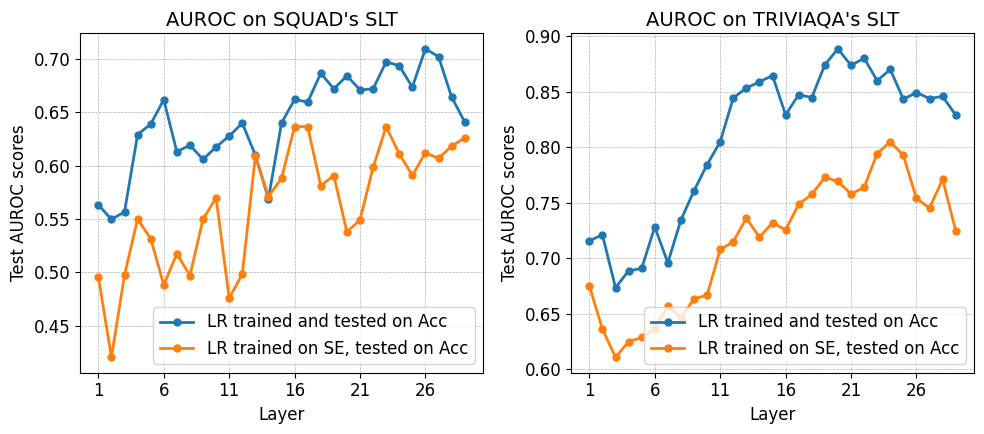

In [41]:
fig, axs = plt.subplots(1, len(Ds), figsize=(5 * len(Ds), 4.5))
for i, D in enumerate(Ds):
    plot_metrics_ax(axs[i], [D.sa_aucs, D.sab_aucs], ["LR trained and tested on Acc", "LR trained on SE, tested on Acc"], f"AUROC on {D.name.upper()}'s SLT")
plt.tight_layout()
save_fig(name="se_for_acc_slt")
plt.show()

In [42]:
# select best layer range (SLT)
def decide_layer_range(Ds, metric='entropy', limit=33): # NOTE: set upperbound to be number of layers+1; e.g. for llama2-70b, it is 81.
    """
    simple logic: use ID average test AUROCs across layers to determine 
    which consecutive range of layers did the best. Do separately
    for SEP and Acc. Pr.
    """
    assert hasattr(Ds[0], 'sab_aucs') and hasattr(Ds[0], 'sa_aucs'), 'previous cells need to be run'
    if 'entropy' in metric:
        aucs = [np.array(auc(D.sab_aucs)) for D in Ds]  # test metrics for ID SEPs
    else:
        aucs = [np.array(auc(D.sa_aucs)) for D in Ds]  # test metrics for ID APs
    best_mean = -np.inf
    best_range = []
    average = lambda a,b : np.mean([np.mean(ac[a:b]) for ac in aucs])

    for i in range(limit):
        for j in range(i+1, limit):
            if j - i < 5: # must be more than 5 layers
                continue
            if average(i, j) > best_mean:
                best_mean = average(i, j)
                best_range = [i, j]

    return best_mean, best_range

emean, (e1, e2) = decide_layer_range(Ds, 'entropy')
amean, (a1, a2) = decide_layer_range(Ds, 'acc')
for D in Ds:
    D.sep_layer_range = (e1, e2)
    D.ap_layer_range = (a1, a2)
print(emean, (e1, e2), amean, (a1, a2))

0.6957896645595478 (21, 26) 0.7789572746094486 (19, 24)


In [43]:
# BOOTSTRAP: select [xx-xx] layers for bootstrapping
def concat_Xs_and_ys(layer_range, X_trains, X_vals, X_tests, y_trains, y_vals, y_tests, 
                     no_val=False, test_only=False):
    """
    Concatenate @params{layer_range} hidden state layers on train/val/test sets.

    no_val: no validation (training set only).
    test_only: no train/validation set (test set only).
    """
    if not no_val:
        X_val_cc = np.concatenate(np.array(X_vals)[layer_range], axis=1)
        y_val_cc = y_vals[layer_range[0]]
    else:
        X_val_cc = y_val_cc = None

    if not test_only:
        X_train_cc = np.concatenate(np.array(X_trains)[layer_range], axis=1)
        y_train_cc = y_trains[layer_range[0]]
    else:
        X_train_cc = y_train_cc = None
    
    X_test_cc = np.concatenate(np.array(X_tests)[layer_range], axis=1)
    y_test_cc = y_tests[layer_range[0]]
    
    return X_train_cc, X_val_cc, X_test_cc, y_train_cc, y_val_cc, y_test_cc

def train_concat_SE(D, layer_range):
    """train model on single dataset SE with concatenated layers"""
    for token_type in ['slt']: # optionally, ['slt', 'tbg']
        var_name = token_type[0]
        all_Xs_and_ys = create_Xs_and_ys(getattr(D, f'{token_type}_dataset'), D.b_entropy, test_only=True) # train on all data
        _, _, X_train_cc, _, _, y_train_cc = concat_Xs_and_ys(layer_range, *all_Xs_and_ys, no_val=True, test_only=True)
        model = LogisticRegression()
        model.fit(X_train_cc, y_train_cc)
        setattr(D, f'{var_name}_bmodel', model)

        print(f'{token_type.upper()} trained on {D.name} SE finished')
    
def train_concat_Acc(D, layer_range):
    """train model on single dataset Accuracy with concatenated layers"""
    for token_type in ['slt']: # optionally, ['slt', 'tbg']
        var_name = token_type[0]
        all_Xs_and_ys = create_Xs_and_ys(getattr(D, f'{token_type}_dataset'), D.accuracies, test_only=True) # train on all data
        _, _, X_train_cc, _, _, y_train_cc = concat_Xs_and_ys(layer_range, *all_Xs_and_ys, no_val=True, test_only=True)
        model = LogisticRegression()
        model.fit(X_train_cc, y_train_cc)
        setattr(D, f'{var_name}_amodel', model)

        print(f'{token_type.upper()} trained on {D.name} Acc finished')

def train_concat_SE_Acc_test_Acc(D, layer_ranges=[list(range(e1,e2)), list(range(a1,a2))]):
    """ID: train and test SEPs and Acc. Pr. on single dataset with concatenated layers"""
    for token_type in ['slt']: # optionally, ['slt', 'tbg']
        var_name = token_type[0]
        all_Xs_and_ys = create_Xs_and_ys(getattr(D, f'{token_type}_dataset'), D.b_entropy, no_val=True) 
        
        X_train_cc, _, _, y_train_cc, _, _ = concat_Xs_and_ys(layer_ranges[0], *all_Xs_and_ys, no_val=True)
        ab_accs = []
        ab_aucs = []
        model = LogisticRegression()
        model.fit(X_train_cc, y_train_cc)

        all_Xs_and_ys = create_Xs_and_ys(getattr(D, f'{token_type}_dataset'), D.accuracies) 
        _, _, X_test_cc, _, _, y_test_cc = concat_Xs_and_ys(layer_ranges[0], *all_Xs_and_ys) # fixed random seed ensures no data leakage
        test_loss, test_acc, test_auc = sklearn_evaluate_on_test(model, X_test_cc, 1-y_test_cc) # SEP predicts error rate
        ab_accs.append(test_acc)
        ab_aucs.append(test_auc)
    
        setattr(D, f'i{var_name}b_accs', ab_accs)  # i means IDß
        setattr(D, f'i{var_name}b_aucs', ab_aucs)

        print(f'{D.name.upper()}-{token_type.upper()} trainied on SE and tested on Acc finished')
        aa_accs = []
        aa_aucs = []
        X_train_cc, _, X_test_cc, y_train_cc, _, y_test_cc = concat_Xs_and_ys(layer_ranges[1], *all_Xs_and_ys, no_val=True)
        model = LogisticRegression()
        model.fit(X_train_cc, y_train_cc)
        test_loss, test_acc, test_auc = sklearn_evaluate_on_test(model, X_test_cc, y_test_cc)
        aa_accs.append(test_acc)
        aa_aucs.append(test_auc)
    
        setattr(D, f'i{var_name}a_accs', aa_accs)
        setattr(D, f'i{var_name}a_aucs', aa_aucs)
        print(f'{D.name.upper()}-{token_type.upper()} trainied on Acc and tested on Acc finished')

In [44]:
# ID: train SEPs and Acc. Pr. and test them on Acc. from the same dataset
# import warnings # uncomment to disable convergence warnings
# warnings.filterwarnings('ignore')

for D in Ds:
    train_concat_SE_Acc_test_Acc(D)

Test Loss: 3.9048, Test Accuracy: 0.5150, AUROC: 0.6070
SQUAD-SLT trainied on SE and tested on Acc finished
Test Loss: 1.3758, Test Accuracy: 0.7600, AUROC: 0.7120
SQUAD-SLT trainied on Acc and tested on Acc finished
Test Loss: 2.4021, Test Accuracy: 0.7300, AUROC: 0.8153
TRIVIAQA-SLT trainied on SE and tested on Acc finished
Test Loss: 0.9742, Test Accuracy: 0.8300, AUROC: 0.8878
TRIVIAQA-SLT trainied on Acc and tested on Acc finished


In [45]:
# OOD: save model trained on individual datasets for OOD tests
for D in Ds:
    train_concat_SE(D, layer_range=list(range(e1,e2)))
    train_concat_Acc(D, layer_range=list(range(a1,a2)))
# outputs cleared for space concern

SLT trained on squad SE finished
SLT trained on squad Acc finished
SLT trained on triviaqa SE finished
SLT trained on triviaqa Acc finished


## Test probes trained with one dataset on others

We generalize SE and Acc. probes to Out-of-Distribution settings (OOD).

In [46]:
# Train on one's Acc/SE and test on others' Acc
def test_one_on_n(D, token_type='slt', 
                  layer_range1=list(range(e1,e2)), 
                  layer_range2=list(range(a1,a2))):
    var_name = token_type[0]
    other_ids = D.other_ids
    other_names = D.other_names
    metric = 'accuracies'
    a_model = getattr(D, f'{var_name}_amodel')  # Acc. Probe
    b_model = getattr(D, f'{var_name}_bmodel')  # SE Probe

    print(f"Using probes trained on datasets {D.name.upper()}'s {token_type.upper()}-SE/Acc to predict {other_names}'s {token_type.upper()}-Acc")

    oa_accs = {}
    oa_aucs = {}
    ob_accs = {}
    ob_aucs = {}
    
    for id_ in D.other_ids:
        D_id = Ds[id_]
        print(f"Testing on {D_id.name.upper()}'s {token_type.upper()}-{metric.upper()}")
        if metric == 'accuracies':
            y_metric = 1 - getattr(D_id, metric)  # error rate
        else:
            y_metric = getattr(D_id, metric)
        
        ida_accs = []
        ida_aucs = []
        idb_accs = []
        idb_aucs = []

        # create test sets with accuracy labels
        all_Xs_and_ys = create_Xs_and_ys(getattr(D_id, f'{token_type}_dataset'), y_metric, test_only=True)

        # test on Acc. Probes
        _, _, X_test_cc, _, _, y_test_cc = concat_Xs_and_ys(layer_range2, *all_Xs_and_ys, no_val=True, test_only=True)
        test_loss, test_acc, test_auc = sklearn_evaluate_on_test(a_model, X_test_cc, 1-y_test_cc, bootstrap=True)
        ida_accs.append(test_acc)
        ida_aucs.append(test_auc)
        
        # test on SE Probes
        _, _, X_test_cc, _, _, y_test_cc = concat_Xs_and_ys(layer_range1, *all_Xs_and_ys, no_val=True, test_only=True)
        test_loss, test_acc, test_auc = sklearn_evaluate_on_test(b_model, X_test_cc, y_test_cc, bootstrap=True)
        idb_accs.append(test_acc)
        idb_aucs.append(test_auc)

        oa_accs[D_id.name] = ida_accs
        oa_aucs[D_id.name] = ida_aucs
        ob_accs[D_id.name] = idb_accs
        ob_aucs[D_id.name] = idb_aucs

    setattr(D, 'osa_accs', oa_accs) # o means OOD
    setattr(D, 'osa_aucs', oa_aucs)
    setattr(D, 'osb_accs', ob_accs)
    setattr(D, 'osb_aucs', ob_aucs)

    print(f"Using probes trained on dataset {D.name.upper()} testing complete.")

In [47]:
for D in Ds:
    test_one_on_n(D, 'slt')

Using probes trained on datasets SQUAD's SLT-SE/Acc to predict ['triviaqa']'s SLT-Acc
Testing on TRIVIAQA's SLT-ACCURACIES
Test Loss: 1.7615, Test Accuracy: 0.6720, AUROC: 0.7522
Test Loss: 2.2723, Test Accuracy: 0.6790, AUROC: 0.7260
Using probes trained on dataset SQUAD testing complete.
Using probes trained on datasets TRIVIAQA's SLT-SE/Acc to predict ['squad']'s SLT-Acc
Testing on SQUAD's SLT-ACCURACIES
Test Loss: 2.4217, Test Accuracy: 0.6425, AUROC: 0.7021
Test Loss: 5.8417, Test Accuracy: 0.4810, AUROC: 0.6726
Using probes trained on dataset TRIVIAQA testing complete.


In [48]:
# compute the OOD average: mean([train on B-> test on A, train on C -> test on A, train on D-> test on A])
b_performances = defaultdict(list)
a_performances = defaultdict(list)
win_rate = []
for D in Ds:
    for name in D.other_names:
        b_performances[name].append(auc(D.osb_aucs[name]))
        a_performances[name].append(auc(D.osa_aucs[name]))
        if auc(D.osb_aucs[name]) > auc(D.osa_aucs[name]):
            win_rate.append(1)
        else:
            win_rate.append(0)

print(f"winning rate: {np.mean(win_rate)*100:.2f}%")

for D in Ds:
    D.sep_ood_avg = np.mean(b_performances[D.name])
    D.ap_ood_avg = np.mean(a_performances[D.name])
    print(f"Average performance on {D.name}: SE Probe - {D.sep_ood_avg}, Acc Probe - {D.ap_ood_avg}")

winning rate: 0.00%
Average performance on squad: SE Probe - 0.6726213476027106, Acc Probe - 0.7021423581160987
Average performance on triviaqa: SE Probe - 0.7259867960769848, Acc Probe - 0.7521995937906792
